# Reference Sample Selection

Autoria: Sabrina Correa (paeslemesa@gmail.com) <br>
Criação: 29/04/2024 <br>
Modificação: 03/06/2024 <br>


## 1. Imports

In [63]:
from importlib import reload
from pathlib import Path

import numpy as np
from scipy import stats

import pandas as pd
import geopandas as gpd
import seaborn as sns

import rasterio
import rasterio.mask

from shapely import box

from tqdm import tqdm

import datetime

import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
import RSS_utils as utils

In [3]:
reload(utils)

class1 = utils.rss()
plots = utils.plotGraphs()

## 2. Opening Images

In [4]:
wkdir = r"D:\Pesquisa\Artigo_Mestrado"
#wkdir = r"/home/jovyan/sabrina/Artigo_Mestrado"

In this sense, there are two images to be used in this process.

Before we match them together, we must check whereas they CRS is the same

In [5]:
fine_img = Path(wkdir, "02_Classificacao_1/S2_classificacao_merge_epsg31981.tif")
coarse_img = Path(wkdir, "01_Imagens/Sentinel3/DownloadGEE/Sentinel3_2023-08-19_2023-08-20_epsg31981.tif")

todayy = datetime.date.today()
formatted_date = todayy.strftime("%Y%m%d")

csv_out = Path(wkdir, f"03_RSS/RSS_results_{formatted_date}.csv")
n_classes = 4

csv_out

WindowsPath('D:/Pesquisa/Artigo_Mestrado/03_RSS/RSS_results_20240716.csv')

### 2.1. Getting Coarse Image information

In this moment, we get the coarse image bouding box (bbox) and its entire metadata.

Counts how many classified pixels from _fine_img_ are within each _corase_img_ pixels as well as the total amount of _fine_img_ within each _corase_img_ pixel.

In [ ]:
df_rss = class1.rss(fine_img, coarse_img, n_classes)

In [44]:
df_rss.to_csv(csv_out, index=False)

## 3. EDA

In [67]:
file_rss =  Path(wkdir, f"03_RSS/RSS_results_20240604.csv")
n_pixels = 900 #number of fine pixels inside a coarse pixel
n_samples = 1500 #number os samples for each class to train the ML model

bands = ["blue", "green", "red", "nir"]


In [15]:
df_rss = pd.read_csv(file_rss)


In [16]:
# Compute Frequency, Percentage and Weight for each row regarding fine pixels within coarse pixel

df_rss2 = class1.rss_EDA(df_rss, n_pixels, n_samples)

In [17]:
df_rss2.to_csv(Path(file_rss.parent, file_rss.stem + "_EDA.csv"), index=False)

In [157]:
approach = 1
pixel_quali = 0.5

folderOut = Path(file_rss.parent, f"Approach_{approach}")
folderOut.mkdir(exist_ok=True)

Filtering data according to each approach and doing simple EDA to each csv file

In [220]:
# Approch 1: Randomly select samples for each class that are [q, 1]
# Approch 2: Randomly select samples for each class that are [q, q+0.05[
# Approach 3: Randomly select samples for each class that are [1]

for approach in tqdm([1, 2, 3]):
    folderOut = Path(file_rss.parent, f"Approach_{approach}")
    folderOut.mkdir(exist_ok=True)
    
    if approach == 3:
        pixel_quali = 1

        df_quali = class1.getCoarseInfo(coarse_img, df_rss2, pixel_quality=pixel_quali, approach=approach)
        df_quali.to_csv(Path(folderOut, f"filteredData_approach{approach}_quali{int(pixel_quali*100)}.csv"), index=False)
        
        h=plots.plot_hist(df_quali, pixel_quali, approach, folderOut, show=False)
        h = None
        v=plots.plot_violin(df_quali, pixel_quali, approach, folderOut, show=False)
        v = None

    else:
        for pixel_quali in plots.qualities:
           
            df_quali = class1.getCoarseInfo(coarse_img, df_rss2, pixel_quality=pixel_quali, approach=approach)
            df_quali.to_csv(Path(folderOut, f"filteredData_approach{approach}_quali{int(pixel_quali*100)}.csv"), index=False)
            
            h=plots.plot_hist(df_quali, pixel_quali, approach, folderOut, show=False)
            h = None
            v=plots.plot_violin(df_quali, pixel_quali, approach, folderOut, show=False)
            v = None


100%|██████████| 3/3 [01:31<00:00, 30.35s/it]


# Applying ML

In [86]:
reload(utils)

class1 = utils.rss()
plots = utils.plotGraphs()
ml = utils.dataSci()

In [78]:
qualities = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]

In [92]:
cm['conf_matrix'].shape

(4, 4)

In [107]:

i = 9
print(i)
print(i//2)

9
4


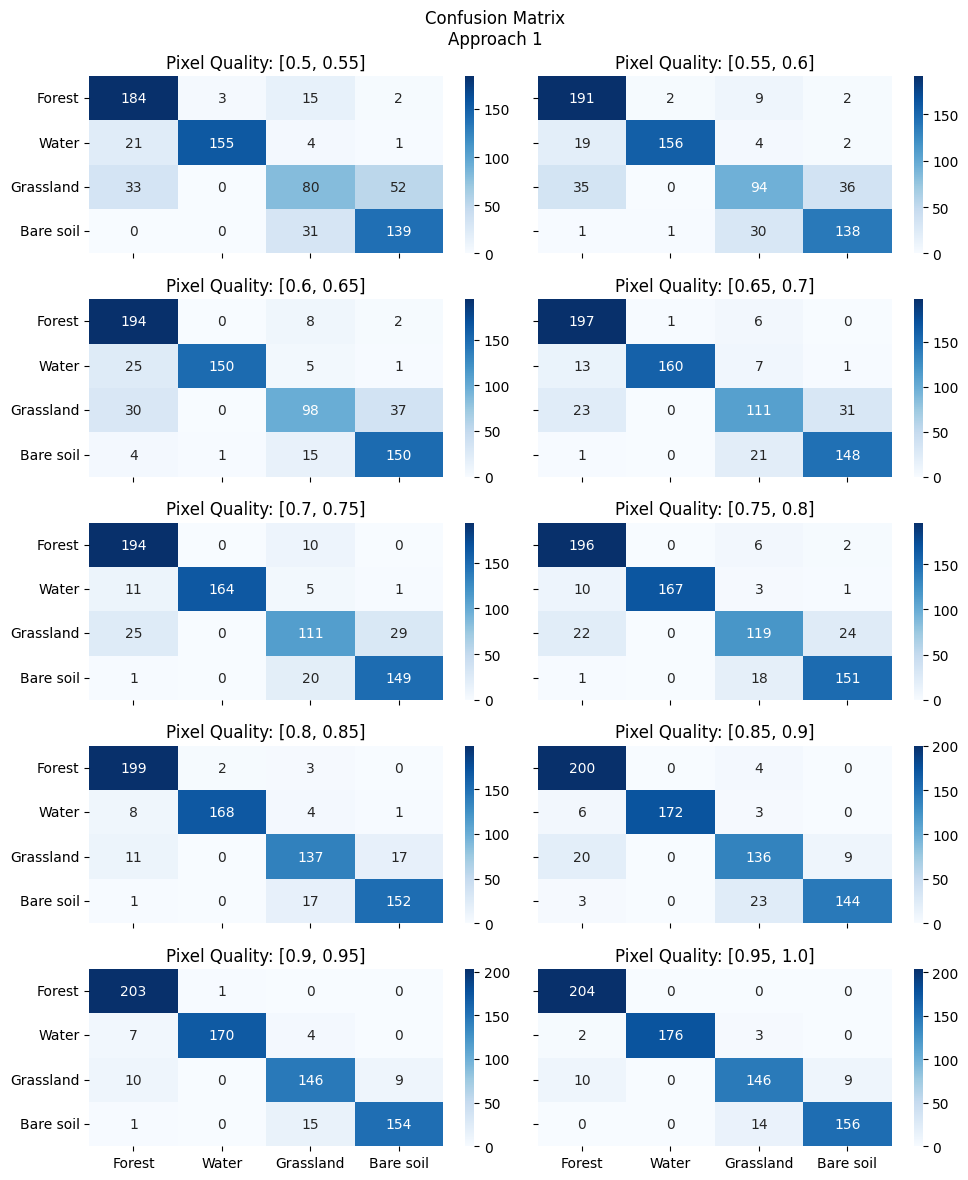

In [123]:
approach = 1
file_rss = r"D:\Pesquisa\Artigo_Mestrado\03_RSS"

fig, ax = plt.subplots(5,2, figsize=(10, 12), sharex=True, sharey=True)
colors_cm = 'Blues'

for i, pixel_quali in enumerate(qualities):

    folderOut = Path(file_rss, f"Approach_{approach}")

    df_quali = pd.read_csv(Path(folderOut, f"filteredData_approach{approach}_quali{int(pixel_quali*100)}.csv"))

    cm = ml.classifier(df_quali)

    if i%2 == 0: j = 0
    else: j = 1
    
    sns.heatmap(cm['conf_matrix'], ax=ax[i//2,j], annot=True, fmt='d', cmap=colors_cm, xticklabels=ml.labels, yticklabels=ml.labels)
    ax[i//2,j].title.set_text(f'Pixel Quality: [{np.round(pixel_quali,2)}, {np.round(pixel_quali+0.05, 2)}]')
 
fig.suptitle(f"Confusion Matrix\nApproach {approach}", fontsize=12)

fig.tight_layout()

# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

<Axes: >

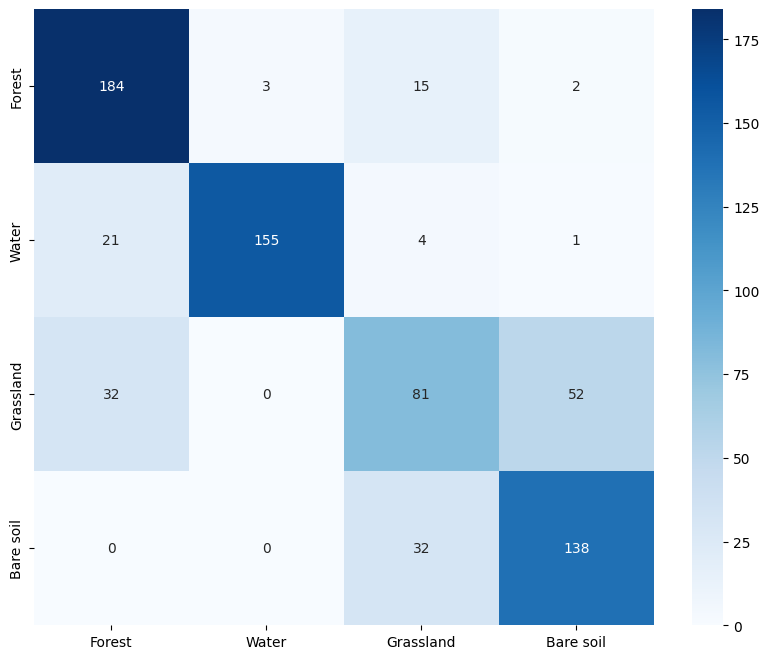

In [46]:
fig, ax = plt.subplots(5,2, figsize=(10, 8))
colors_cm = 'Blues'
for i in range(9):

    sns.heatmap(, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap=colors_cm, ax=ax)

{'Forest': ([np.float64(0.09803921568627451), np.float64(0.22362869198312235)],), 'Water': ([np.float64(0.143646408839779), np.float64(0.0189873417721519)],), 'Grassland': ([np.float64(0.509090909090909), np.float64(0.38636363636363635)],), 'Bare soil': ([np.float64(0.18823529411764706), np.float64(0.2849740932642487)],)}
